In [1]:
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
img_size = 64
num_epochs = 2 #50
learning_rate = 3e-4
num_channels = 3
z_dim = 100

In [3]:
transformer = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5 for _ in range(num_channels)], std = [0.5 for _ in range(num_channels)])
])

In [4]:
dataset = ImageFolder(root = "data_small/celeba_hq_256", 
                      transform = transformer) 

In [5]:
train_dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)
train_dataloader

In [ ]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

# convTranspose2d dimensions
Output Height=(Input Height−1)×stride−2×padding+kernel size+output padding[](http://)

# Generator

In [6]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [7]:
class Generator(nn.Module):
    def __init__(self, z_dim, num_channels):
        super(Generator,self).__init__()
        self.gen = nn.Sequential(
            self._block(z_dim,1024,1,0,4),
            self._block(1024, 512,2,0,2),
            self._block(512, 256,2,0,2),
            self._block(256, 128,2,0,2),
            nn.ConvTranspose2d(in_channels = 128, 
                           out_channels = num_channels, 
                           stride = 2, 
                           kernel_size = 2,
                           padding = 0),
            nn.Tanh()
        )
    def _block(self,in_channels, out_channels, stride, padding, kernel_size):
        block = nn.Sequential(
            nn.ConvTranspose2d(in_channels = in_channels, 
                           out_channels = out_channels, 
                           kernel_size = kernel_size,
                           stride = stride, 
                           padding = padding,
                              bias = False),
            nn.LeakyReLU(0.2)
        )
        return block
    
    def forward(self,x):
        return self.gen(x)

class Dis(nn.Module):
    def __init__(self,num_channels):
        super(Dis,self).__init__()
        self.dis = nn.Sequential(
            self._block(num_channels, 64,2,1,4),
            self._block(64, 128,2,0,2),
            self._block(128,256 ,2,0,2),
            self._block(256,512 ,2,0,2),
            nn.Conv2d(64 * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )
        pass
    def _block(self,in_channels, out_channels, stride, padding, kernel_size):
        block = nn.Sequential(
            nn.Conv2d(in_channels = in_channels, 
                           out_channels = out_channels, 
                           stride = stride, 
                           padding = padding,
                     kernel_size=kernel_size,
                     bias = False),
#             nn.BatchNormalization(),
            nn.LeakyReLU(0.2)
        )
        return block
    
    def forward(self,x):
        return self.dis(x)
    
gen = Generator(100,3).to(device)
disc = Dis(3).to(device)
# print(summary(disc, input_size=[1, 3, 64, 64]))
# summary(gen, input_size=[1, 100, 1, 1])

In [ ]:
def test():
    N, in_channels, H, W = 8, 3, 64, 64
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Dis(in_channels)
    assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
    gen = Generator(noise_dim, in_channels)
    z = torch.randn((N, noise_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"
    print("Success, tests passed!")
test()

In [8]:
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 2e-4  # could also use two lrs, one for gen and one for disc
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 1
NOISE_DIM = 100
NUM_EPOCHS = 2 #30
FEATURES_DISC = 64
FEATURES_GEN = 64

initialize_weights(gen)
initialize_weights(disc)
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0
gen.train()
disc.train()

for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (real, _) in enumerate(train_dataloader):
        real = real.to(device)
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
        fake = gen(noise)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 500 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(train_dataloader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1

Epoch [0/2] Batch 0/5                   Loss D: 0.6936, loss G: 0.6926
Epoch [1/2] Batch 0/5                   Loss D: 0.6588, loss G: 0.6942


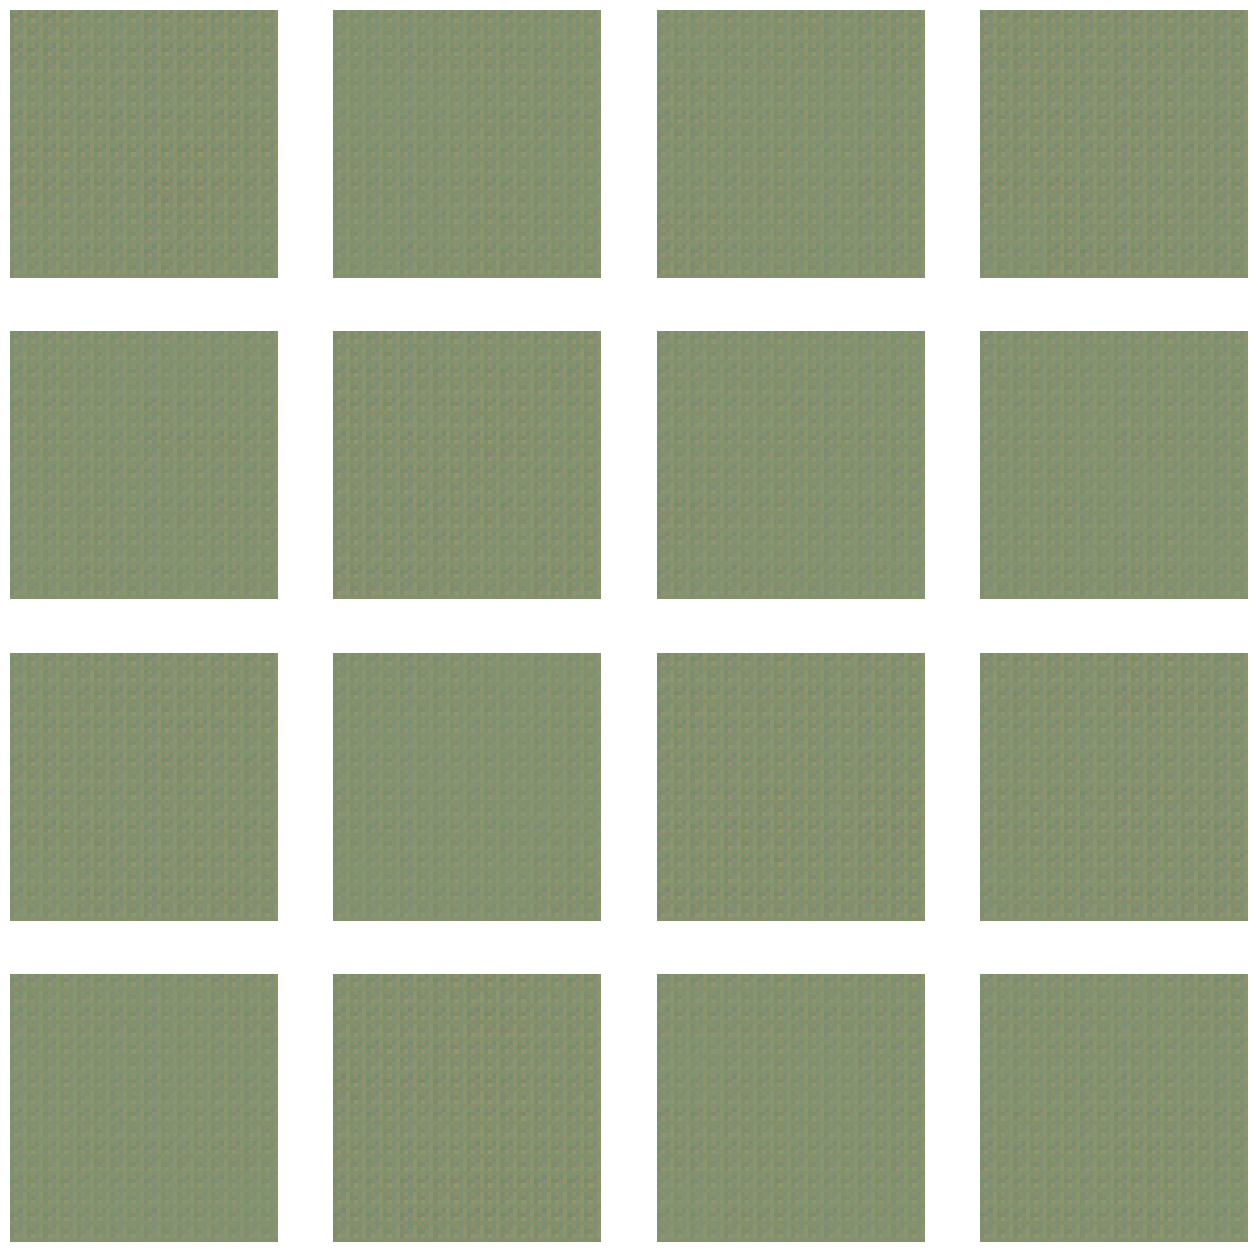

In [9]:
import matplotlib.pyplot as plt 
def visual():
    
    # fix --- total 16, n*n=16
#     n=6
    n=4
    
    k=0
    z = torch.randn((16, 100, 1, 1)).to(device)
    out= gen(z)
    plt.figure(figsize=(16,16))
    out = out.cpu()
    out = out.detach().numpy()
    for i in range(n):
        for j in range(n):
            ax=plt.subplot(n,n,k+1)
            img = (out[k]+1)/2
            img = np.transpose(img,(1,2,0))
            plt.imshow(img)
            plt.axis('off')
            k+=1
visual()

In [ ]:
import os
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))
download_file('/kaggle/working', 'dcganLogs1')


In [ ]:
class Gen(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Gen, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            # nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            # nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

In [ ]:
g = Gen(100,3,64)
d = Discriminator(3)
print(summary(d, input_size=[1, 3, 64, 64]))
summary(g, input_size=[1, 100, 1, 1])